<a href="https://colab.research.google.com/github/sravani-1903/DATA-PIPELINE-DEVELOPMENT/blob/main/DATA_PIPELINE_DEVELOPMENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dummy CSV created at: dummy_data.csv
🚀 Advanced Data Pipeline Initialized
📊 Configuration: 5 sections loaded

📊 Generating Initial Quality Report
📈 Dataset Overview:
   • Rows: 100
   • Columns: 9
   • Memory: 0.02 MB
   • Duplicates: 0

🔍 Data Types:
   • Numeric: 6
   • Categorical: 3
   • DateTime: 0
   • Boolean: 0

⚠️  Missing Values:
   • Total Missing: 22
   • Missing Rate: 2.44%
   • Affected Columns: 2

📈 Generating Data Quality Visualizations...


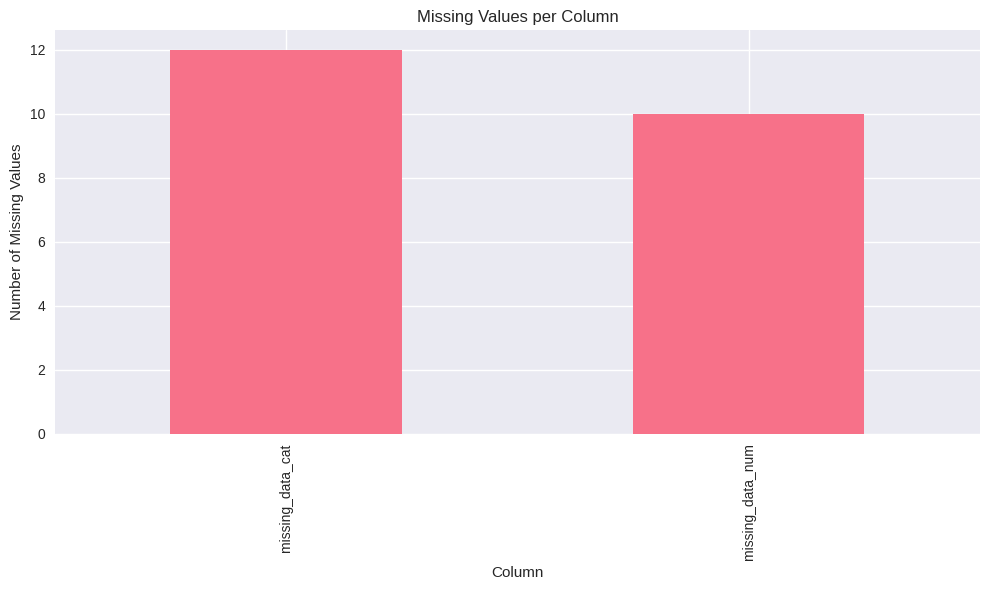

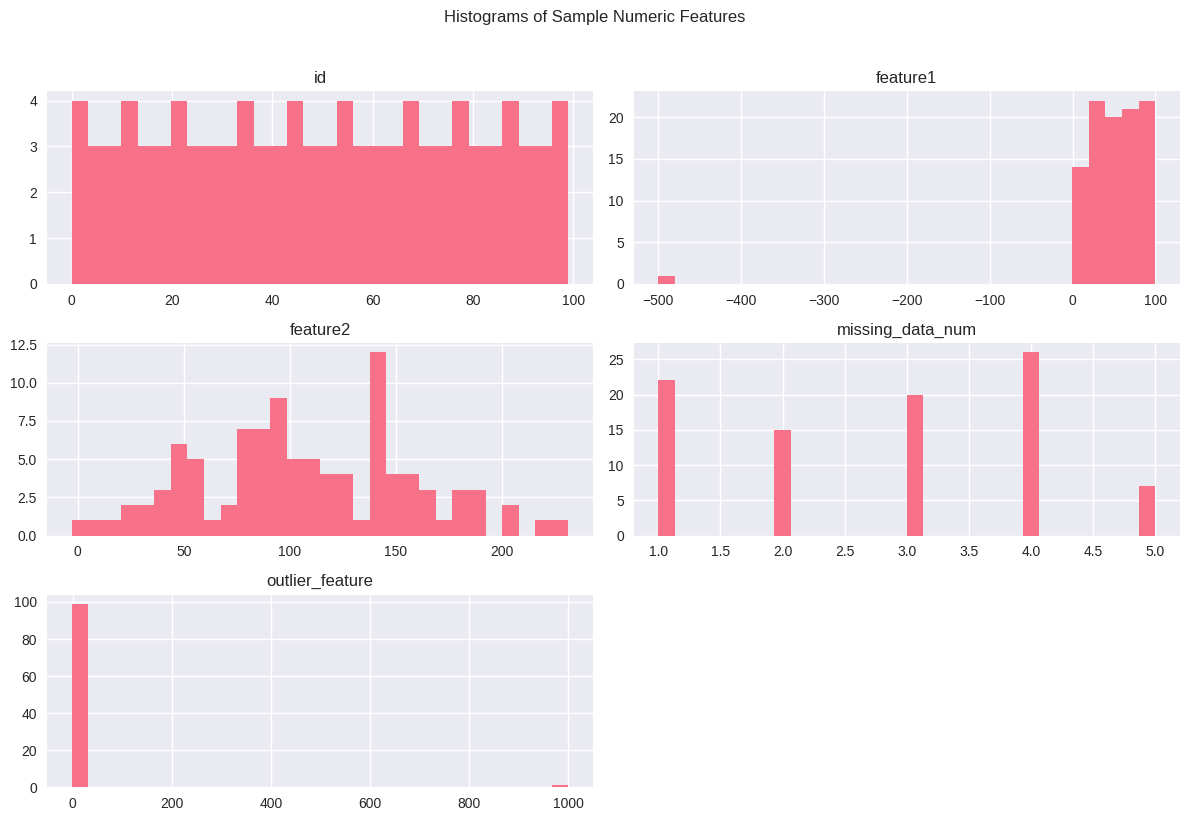

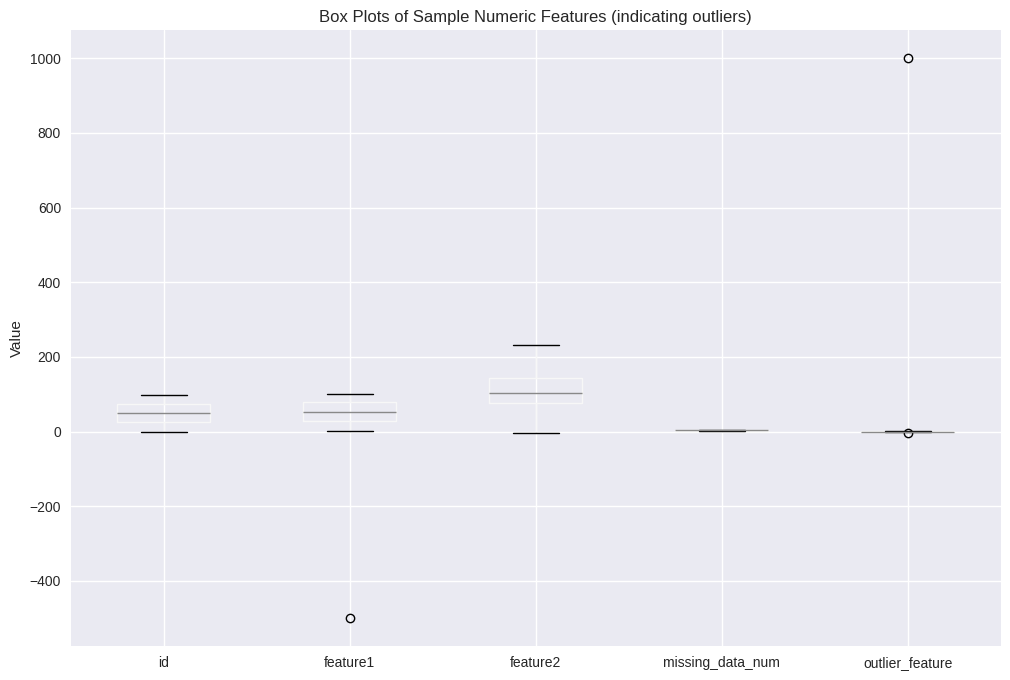

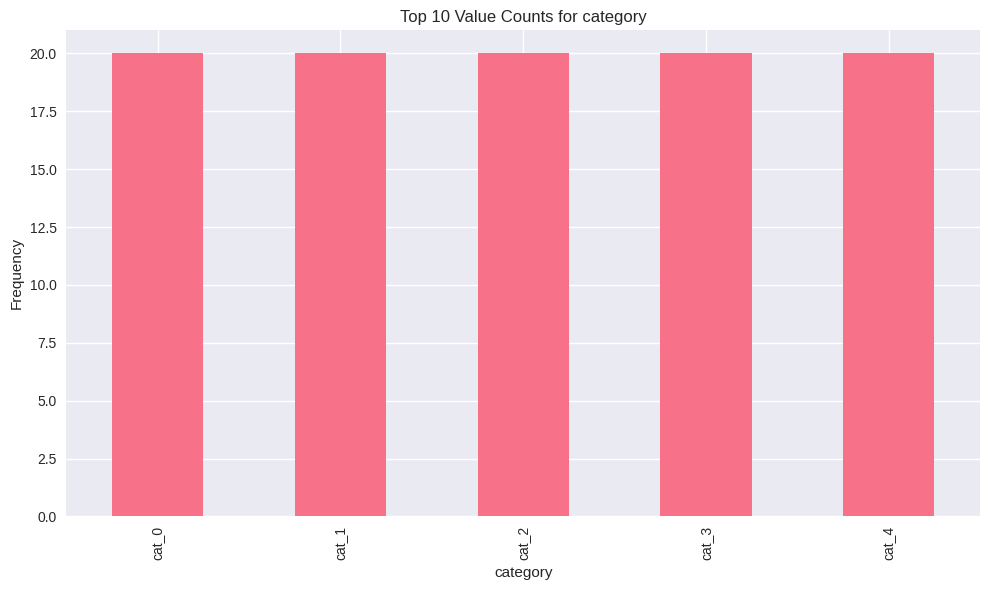

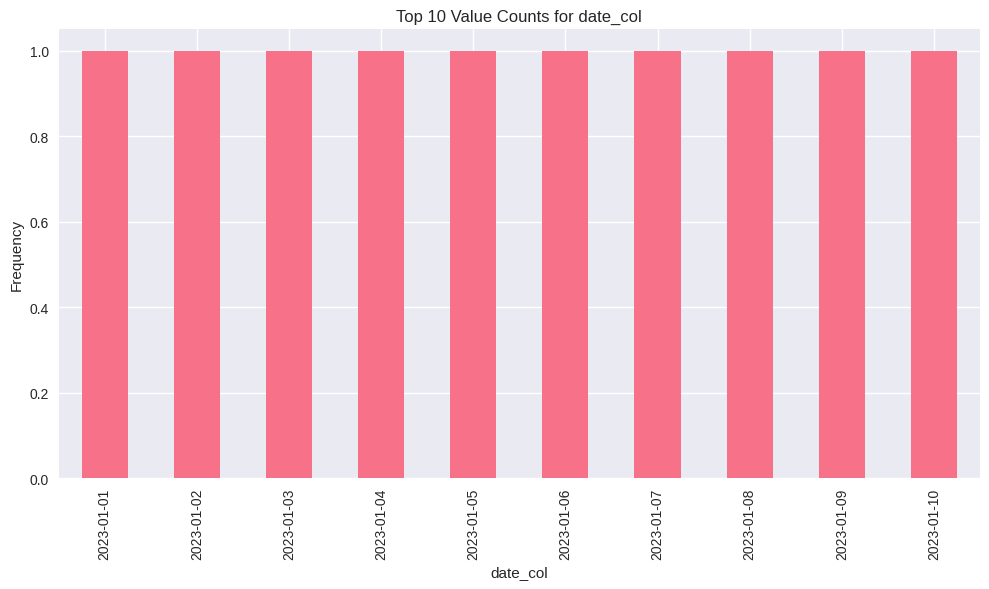

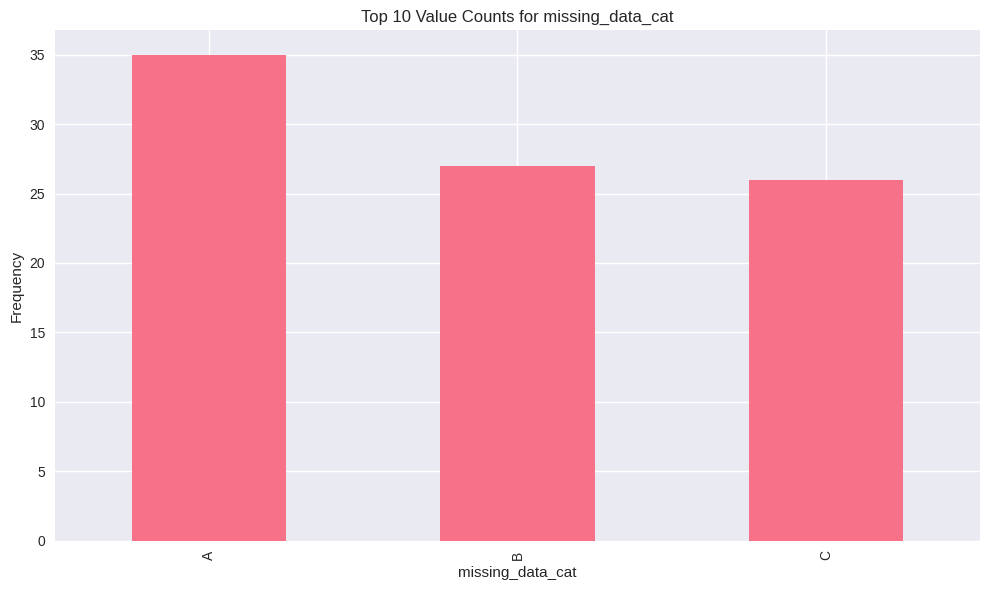


📊 Generating Post-ETL Quality Report
📈 Dataset Overview:
   • Rows: 90
   • Columns: 45
   • Memory: 0.03 MB
   • Duplicates: 0

🔍 Data Types:
   • Numeric: 36
   • Categorical: 0
   • DateTime: 0
   • Boolean: 9

⚠️  Missing Values:
   • Total Missing: 0
   • Missing Rate: 0.00%

📈 Generating Data Quality Visualizations...


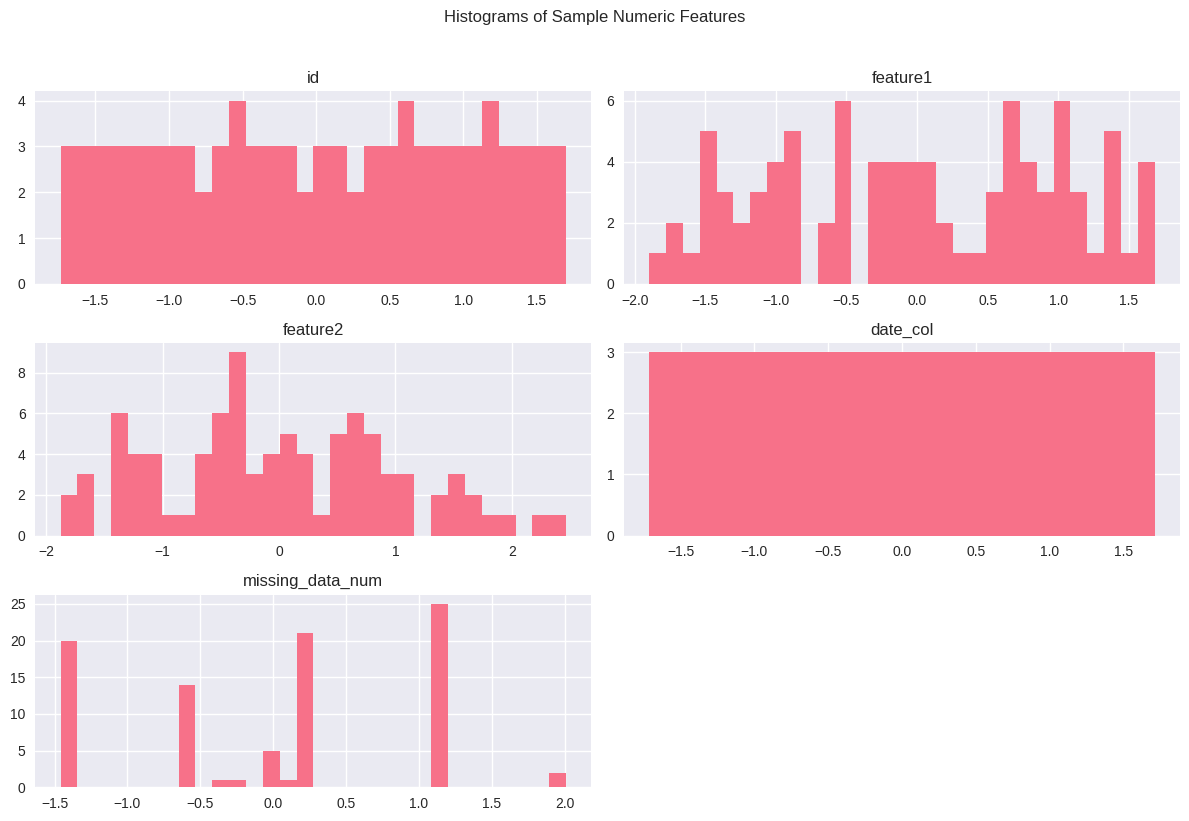

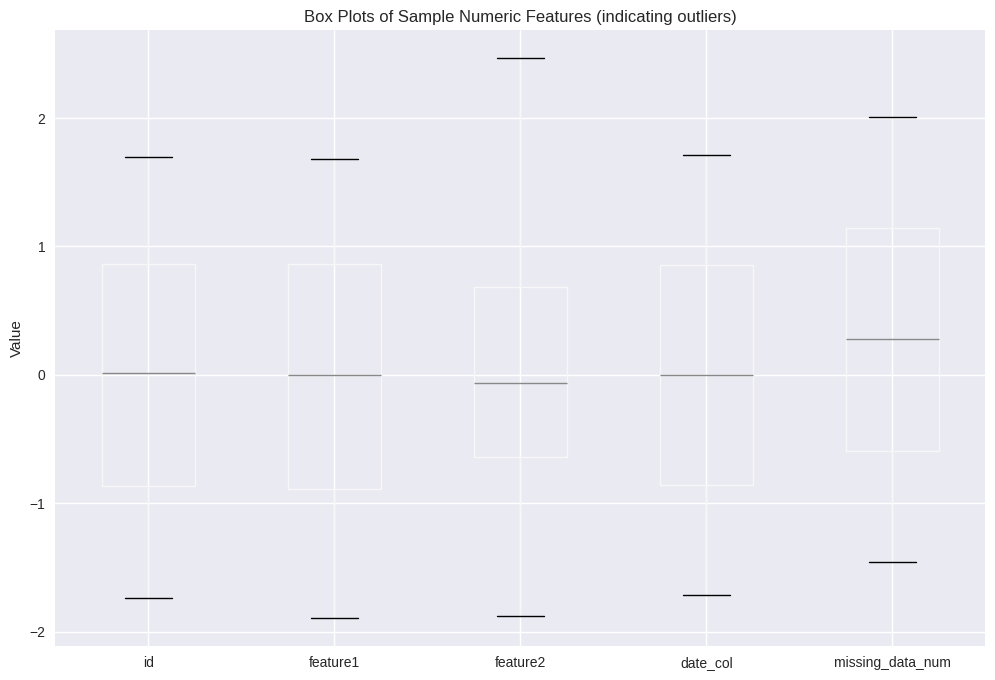

ERROR:__main__:💥 Pipeline failed: Object of type int64 is not JSON serializable



Processed Data Head:
         id  feature1  feature2  date_col  missing_data_num  outlier_feature  \
1 -1.736704 -0.559672 -0.010573 -1.712912          1.142412        -0.836802   
2 -1.700920 -0.282310  0.033809 -1.674419         -1.458358        -0.960433   
4 -1.629352 -0.951667  1.590508 -1.635927          1.142412        -0.102038   
5 -1.593569 -0.537572 -1.073780 -1.597434         -1.458358        -1.684958   
6 -1.557785  0.024820 -1.383874 -1.558942          1.142412         1.339026   

     target  category_cat_0  category_cat_1  category_cat_2  category_cat_3  \
1  1.118034           False            True           False           False   
2 -0.894427           False           False            True           False   
4 -0.894427           False           False           False           False   
5 -0.894427            True           False           False           False   
6  1.118034           False            True           False           False   

   category_cat_4  mis

In [2]:
# %% [markdown]
# # Complete Data Pipeline for ETL Processing
#
# This notebook provides a comprehensive data pipeline for Extract, Transform, and Load (ETL) operations
# using pandas and scikit-learn. The pipeline includes data preprocessing, transformation, and loading
# with automated quality checks and visualization capabilities.

# %% [markdown]
# ## 1. Setup and Configuration

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sqlite3
import json
import logging
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union

# Scikit-learn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.compose import ColumnTransformer

# Configure display and warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# %%
class AdvancedDataPipeline:
    """
    Advanced ETL Data Pipeline with comprehensive preprocessing and transformation capabilities
    """

    def __init__(self, config: Dict = None):
        """Initialize pipeline with configuration"""
        self.config = config or self._get_default_config()
        self.transformers = {}
        self.feature_names = []
        self.pipeline_history = []
        self.data_quality_reports = []

        # Setup logging
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
        self.logger = logging.getLogger(__name__)

        print("🚀 Advanced Data Pipeline Initialized")
        print(f"📊 Configuration: {len(self.config)} sections loaded")

    def _get_default_config(self) -> Dict:
        """Get default pipeline configuration"""
        return {
            'data_sources': {
                'supported_formats': ['csv', 'excel', 'json', 'parquet', 'sql']
            },
            'preprocessing': {
                'missing_value_threshold': 0.5,
                'outlier_detection_method': 'isolation_forest',
                'scaling_method': 'standard',
                'encoding_method': 'label'
            },
            'feature_engineering': {
                'create_interactions': True,
                'polynomial_features': False,
                'pca_components': None,
                'feature_selection': True
            },
            'output': {
                'save_intermediate_steps': True,
                'generate_report': True,
                'visualization': True
            }
        }

    def log_step(self, step_name: str, details: Dict):
        """Log pipeline step with timestamp"""
        log_entry = {
            'timestamp': datetime.now().isoformat(),
            'step': step_name,
            'details': details
        }
        self.pipeline_history.append(log_entry)
        self.logger.info(f"✅ {step_name}: {details}")

# %% [markdown]
# ## 2. Data Extraction Module

# %%
class DataExtractor:
    """Handles data extraction from various sources"""

    def __init__(self, pipeline_instance):
        self.pipeline = pipeline_instance

    def extract_from_csv(self, file_path: str, **kwargs) -> pd.DataFrame:
        """Extract data from CSV with error handling and validation"""
        try:
            # Auto-detect encoding if not specified
            if 'encoding' not in kwargs:
                kwargs['encoding'] = self._detect_encoding(file_path)

            df = pd.read_csv(file_path, **kwargs)

            self.pipeline.log_step('EXTRACT_CSV', {
                'source': file_path,
                'shape': df.shape,
                'memory_usage': f"{df.memory_usage(deep=True).sum() / 1024**2:.2f} MB"
            })

            return df

        except Exception as e:
            self.pipeline.logger.error(f"❌ CSV extraction failed: {e}")
            raise

    def extract_from_excel(self, file_path: str, sheet_name: str = None, **kwargs) -> pd.DataFrame:
        """Extract data from Excel files"""
        try:
            df = pd.read_excel(file_path, sheet_name=sheet_name, **kwargs)

            self.pipeline.log_step('EXTRACT_EXCEL', {
                'source': file_path,
                'sheet': sheet_name or 'default',
                'shape': df.shape
            })

            return df

        except Exception as e:
            self.pipeline.logger.error(f"❌ Excel extraction failed: {e}")
            raise

    def extract_from_database(self, connection_string: str, query: str) -> pd.DataFrame:
        """Extract data from SQL database"""
        try:
            conn = sqlite3.connect(connection_string)
            df = pd.read_sql_query(query, conn)
            conn.close()

            self.pipeline.log_step('EXTRACT_DATABASE', {
                'source': connection_string,
                'query_preview': query[:100] + '...' if len(query) > 100 else query,
                'shape': df.shape
            })

            return df

        except Exception as e:
            self.pipeline.logger.error(f"❌ Database extraction failed: {e}")
            raise

    def extract_from_json(self, file_path: str, **kwargs) -> pd.DataFrame:
        """Extract data from JSON files"""
        try:
            df = pd.read_json(file_path, **kwargs)

            self.pipeline.log_step('EXTRACT_JSON', {
                'source': file_path,
                'shape': df.shape
            })

            return df

        except Exception as e:
            self.pipeline.logger.error(f"❌ JSON extraction failed: {e}")
            raise

    def _detect_encoding(self, file_path: str) -> str:
        """Detect file encoding"""
        try:
            import chardet
            with open(file_path, 'rb') as f:
                result = chardet.detect(f.read(10000))
            return result['encoding']
        except ImportError:
            return 'utf-8'

# %% [markdown]
# ## 3. Data Quality Assessment

# %%
class DataQualityAnalyzer:
    """Comprehensive data quality analysis"""

    def __init__(self, pipeline_instance):
        self.pipeline = pipeline_instance

    def generate_quality_report(self, df: pd.DataFrame, report_name: str = "Data Quality Report") -> Dict:
        """Generate comprehensive data quality report"""

        print(f"\n📊 Generating {report_name}")
        print("=" * 60)

        # Basic statistics
        basic_stats = {
            'total_rows': len(df),
            'total_columns': len(df.columns),
            'memory_usage_mb': df.memory_usage(deep=True).sum() / 1024**2,
            'duplicate_rows': df.duplicated().sum()
        }

        # Missing values analysis
        missing_analysis = {
            'columns_with_missing': df.isnull().sum()[df.isnull().sum() > 0].to_dict(),
            'total_missing_values': df.isnull().sum().sum(),
            'missing_percentage': (df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100
        }

        # Data types analysis
        dtype_analysis = {
            'numeric_columns': df.select_dtypes(include=[np.number]).columns.tolist(),
            'categorical_columns': df.select_dtypes(include=['object', 'category']).columns.tolist(),
            'datetime_columns': df.select_dtypes(include=['datetime']).columns.tolist(),
            'boolean_columns': df.select_dtypes(include=['bool']).columns.tolist()
        }

        # Statistical summary for numeric columns
        numeric_summary = {}
        if dtype_analysis['numeric_columns']:
            numeric_df = df[dtype_analysis['numeric_columns']]
            numeric_summary = {
                'mean': numeric_df.mean().to_dict(),
                'median': numeric_df.median().to_dict(),
                'std': numeric_df.std().to_dict(),
                'min': numeric_df.min().to_dict(),
                'max': numeric_df.max().to_dict(),
                'skewness': numeric_df.skew().to_dict(),
                'kurtosis': numeric_df.kurtosis().to_dict()
            }

        # Categorical summary
        categorical_summary = {}
        if dtype_analysis['categorical_columns']:
            for col in dtype_analysis['categorical_columns']:
                categorical_summary[col] = {
                    'unique_values': df[col].nunique(),
                    'top_value': df[col].mode().iloc[0] if not df[col].mode().empty else None,
                    'top_value_frequency': df[col].value_counts().iloc[0] if not df[col].empty else 0
                }

        # Compile complete report
        quality_report = {
            'report_name': report_name,
            'timestamp': datetime.now().isoformat(),
            'basic_statistics': basic_stats,
            'missing_values': missing_analysis,
            'data_types': dtype_analysis,
            'numeric_summary': numeric_summary,
            'categorical_summary': categorical_summary
        }

        # Store report
        self.pipeline.data_quality_reports.append(quality_report)

        # Display summary
        self._display_quality_summary(quality_report)

        return quality_report

    def _display_quality_summary(self, report: Dict):
        """Display formatted quality summary"""
        basic = report['basic_statistics']
        missing = report['missing_values']
        dtypes = report['data_types']

        print(f"📈 Dataset Overview:")
        print(f"   • Rows: {basic['total_rows']:,}")
        print(f"   • Columns: {basic['total_columns']}")
        print(f"   • Memory: {basic['memory_usage_mb']:.2f} MB")
        print(f"   • Duplicates: {basic['duplicate_rows']:,}")

        print(f"\n🔍 Data Types:")
        print(f"   • Numeric: {len(dtypes['numeric_columns'])}")
        print(f"   • Categorical: {len(dtypes['categorical_columns'])}")
        print(f"   • DateTime: {len(dtypes['datetime_columns'])}")
        print(f"   • Boolean: {len(dtypes['boolean_columns'])}")

        print(f"\n⚠️  Missing Values:")
        print(f"   • Total Missing: {missing['total_missing_values']:,}")
        print(f"   • Missing Rate: {missing['missing_percentage']:.2f}%")

        if missing['columns_with_missing']:
            print(f"   • Affected Columns: {len(missing['columns_with_missing'])}")

    def detect_outliers(self, df: pd.DataFrame, method: str = 'isolation_forest') -> Dict:
        """Detect outliers using various methods"""
        numeric_cols = df.select_dtypes(include=[np.number]).columns

        if len(numeric_cols) == 0:
            return {'outliers_detected': 0, 'method': method, 'affected_columns': []}

        outlier_results = {}

        if method == 'isolation_forest':
            iso_forest = IsolationForest(contamination=0.1, random_state=42)
            outlier_mask = iso_forest.fit_predict(df[numeric_cols])
            outlier_indices = df.index[outlier_mask == -1].tolist()

        elif method == 'iqr':
            outlier_indices = []
            for col in numeric_cols:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                col_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()
                outlier_indices.extend(col_outliers)
            outlier_indices = list(set(outlier_indices))

        elif method == 'zscore':
            z_scores = np.abs((df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std())
            outlier_mask = (z_scores > 3).any(axis=1)
            outlier_indices = df.index[outlier_mask].tolist()

        outlier_results = {
            'method': method,
            'outliers_detected': len(outlier_indices),
            'outlier_indices': outlier_indices,
            'outlier_percentage': (len(outlier_indices) / len(df)) * 100,
            'affected_columns': numeric_cols.tolist()
        }

        print(f"\n🎯 Outlier Detection ({method}):")
        print(f"   • Outliers Found: {len(outlier_indices)} ({outlier_results['outlier_percentage']:.2f}%)")

        return outlier_results

# %% [markdown]
# ## 4. Data Transformation Module

# %%
class DataTransformer:
    """Advanced data transformation capabilities"""

    def __init__(self, pipeline_instance):
        self.pipeline = pipeline_instance
        self.fitted_transformers = {}

    def handle_missing_values(self, df: pd.DataFrame, strategy: Dict = None) -> pd.DataFrame:
        """Advanced missing value handling"""

        if strategy is None:
            strategy = {
                'numeric': 'mean',
                'categorical': 'most_frequent',
                'advanced': False
            }

        df_clean = df.copy()

        # Separate column types
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

        transformations_applied = []

        # Handle numeric columns
        if numeric_cols:
            if strategy.get('advanced', False):
                # Use KNN Imputer for better results
                imputer = KNNImputer(n_neighbors=5)
                df_clean[numeric_cols] = imputer.fit_transform(df_clean[numeric_cols])
                self.fitted_transformers['numeric_imputer'] = imputer
                transformations_applied.append(f"KNN imputation for {len(numeric_cols)} numeric columns")
            else:
                # Use simple imputer
                imputer = SimpleImputer(strategy=strategy['numeric'])
                df_clean[numeric_cols] = imputer.fit_transform(df_clean[numeric_cols])
                self.fitted_transformers['numeric_imputer'] = imputer
                transformations_applied.append(f"{strategy['numeric']} imputation for {len(numeric_cols)} numeric columns")

        # Handle categorical columns
        if categorical_cols:
            imputer = SimpleImputer(strategy=strategy['categorical'])
            df_clean[categorical_cols] = imputer.fit_transform(df_clean[categorical_cols].astype(str))
            self.fitted_transformers['categorical_imputer'] = imputer
            transformations_applied.append(f"{strategy['categorical']} imputation for {len(categorical_cols)} categorical columns")

        missing_before = df.isnull().sum().sum()
        missing_after = df_clean.isnull().sum().sum()

        self.pipeline.log_step('MISSING_VALUE_HANDLING', {
            'missing_before': missing_before,
            'missing_after': missing_after,
            'values_imputed': missing_before - missing_after,
            'transformations': transformations_applied
        })

        return df_clean

    def remove_outliers(self, df: pd.DataFrame, method: str = 'isolation_forest', contamination: float = 0.1) -> pd.DataFrame:
        """Remove outliers with multiple methods"""

        df_clean = df.copy()
        numeric_cols = df.select_dtypes(include=[np.number]).columns

        if len(numeric_cols) == 0:
            return df_clean

        initial_rows = len(df_clean)

        if method == 'isolation_forest':
            iso_forest = IsolationForest(contamination=contamination, random_state=42)
            outlier_mask = iso_forest.fit_predict(df_clean[numeric_cols])
            df_clean = df_clean[outlier_mask == 1]
            self.fitted_transformers['outlier_detector'] = iso_forest

        elif method == 'iqr':
            for col in numeric_cols:
                Q1 = df_clean[col].quantile(0.25)
                Q3 = df_clean[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

        elif method == 'modified_zscore':
            from scipy.stats import median_absolute_deviation
            for col in numeric_cols:
                median = df_clean[col].median()
                mad = median_absolute_deviation(df_clean[col], nan_policy='omit')
                modified_z_scores = 0.6745 * (df_clean[col] - median) / mad
                df_clean = df_clean[np.abs(modified_z_scores) < 3.5]

        removed_rows = initial_rows - len(df_clean)

        self.pipeline.log_step('OUTLIER_REMOVAL', {
            'method': method,
            'initial_rows': initial_rows,
            'final_rows': len(df_clean),
            'removed_outliers': removed_rows,
            'removal_percentage': (removed_rows / initial_rows) * 100
        })

        return df_clean

    def encode_categorical_variables(self, df: pd.DataFrame, encoding_config: Dict = None) -> pd.DataFrame:
        """Advanced categorical encoding"""

        if encoding_config is None:
            encoding_config = {
                'method': 'auto',  # 'label', 'onehot', 'target', 'auto'
                'handle_unknown': 'ignore',
                'max_categories': 10
            }

        df_encoded = df.copy()
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

        if not categorical_cols:
            return df_encoded

        encoding_summary = []

        for col in categorical_cols:
            unique_values = df_encoded[col].nunique()

            # Auto-select encoding method
            if encoding_config['method'] == 'auto':
                if unique_values <= 2:
                    method = 'label'
                elif unique_values <= encoding_config['max_categories']:
                    method = 'onehot'
                else:
                    method = 'label'
            else:
                method = encoding_config['method']

            if method == 'label':
                encoder = LabelEncoder()
                df_encoded[col] = encoder.fit_transform(df_encoded[col].astype(str))
                self.fitted_transformers[f'{col}_label_encoder'] = encoder
                encoding_summary.append(f"{col}: Label encoding ({unique_values} categories)")

            elif method == 'onehot':
                # One-hot encoding
                dummies = pd.get_dummies(df_encoded[col], prefix=col, dummy_na=False)
                df_encoded = df_encoded.drop(col, axis=1)
                df_encoded = pd.concat([df_encoded, dummies], axis=1)
                encoding_summary.append(f"{col}: One-hot encoding ({unique_values} → {len(dummies.columns)} columns)")

        self.pipeline.log_step('CATEGORICAL_ENCODING', {
            'columns_processed': len(categorical_cols),
            'encoding_details': encoding_summary,
            'final_shape': df_encoded.shape
        })

        return df_encoded

    def scale_features(self, df: pd.DataFrame, method: str = 'standard', columns: List[str] = None) -> pd.DataFrame:
        """Scale numerical features"""

        df_scaled = df.copy()

        if columns is None:
            numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        else:
            numeric_cols = [col for col in columns if col in df.columns]

        if not numeric_cols:
            return df_scaled

        # Select scaler
        if method == 'standard':
            scaler = StandardScaler()
        elif method == 'minmax':
            scaler = MinMaxScaler()
        elif method == 'robust':
            scaler = RobustScaler()
        else:
            raise ValueError(f"Unsupported scaling method: {method}")

        # Fit and transform
        df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])
        self.fitted_transformers[f'{method}_scaler'] = scaler

        self.pipeline.log_step('FEATURE_SCALING', {
            'method': method,
            'columns_scaled': len(numeric_cols),
            'scaler_saved': True
        })

        return df_scaled

    def create_polynomial_features(self, df: pd.DataFrame, degree: int = 2, columns: List[str] = None) -> pd.DataFrame:
        """Create polynomial features"""
        from sklearn.preprocessing import PolynomialFeatures

        df_poly = df.copy()

        if columns is None:
            numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        else:
            numeric_cols = [col for col in columns if col in df.columns]

        if not numeric_cols or len(numeric_cols) > 5:  # Limit to prevent explosion
            numeric_cols = numeric_cols[:5]

        poly = PolynomialFeatures(degree=degree, include_bias=False)
        poly_features = poly.fit_transform(df_poly[numeric_cols])

        # Create feature names
        feature_names = poly.get_feature_names_out(numeric_cols)

        # Create DataFrame with polynomial features
        poly_df = pd.DataFrame(poly_features, columns=feature_names, index=df_poly.index)

        # Drop original columns to avoid duplication
        df_poly = df_poly.drop(columns=numeric_cols)
        df_poly = pd.concat([df_poly, poly_df], axis=1)

        self.fitted_transformers['polynomial_features'] = poly

        self.pipeline.log_step('POLYNOMIAL_FEATURES', {
            'degree': degree,
            'original_features': len(numeric_cols),
            'polynomial_features': len(feature_names),
            'total_features': len(df_poly.columns)
        })

        return df_poly

# %% [markdown]
# ## 5. Feature Engineering Module

# %%
class FeatureEngineer:
    """Advanced feature engineering capabilities"""

    def __init__(self, pipeline_instance):
        self.pipeline = pipeline_instance

    def create_interaction_features(self, df: pd.DataFrame, max_interactions: int = 10) -> pd.DataFrame:
        """Create interaction features between numerical columns"""

        df_features = df.copy()
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

        if len(numeric_cols) < 2:
            return df_features

        interactions_created = 0
        interaction_names = []

        # Limit combinations to prevent feature explosion
        from itertools import combinations

        for i, (col1, col2) in enumerate(combinations(numeric_cols, 2)):
            if interactions_created >= max_interactions:
                break

            interaction_name = f'{col1}_x_{col2}'
            df_features[interaction_name] = df_features[col1] * df_features[col2]
            interaction_names.append(interaction_name)
            interactions_created += 1

        self.pipeline.log_step('INTERACTION_FEATURES', {
            'interactions_created': interactions_created,
            'feature_names': interaction_names[:5] + ['...'] if len(interaction_names) > 5 else interaction_names
        })

        return df_features

    def create_statistical_features(self, df: pd.DataFrame, window_cols: List[str] = None) -> pd.DataFrame:
        """Create statistical features (rolling, lag, etc.)"""

        df_stats = df.copy()

        if window_cols is None:
            numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        else:
            numeric_cols = [col for col in window_cols if col in df.columns]

        if not numeric_cols:
            return df_stats

        stats_created = []

        for col in numeric_cols[:3]:  # Limit to prevent explosion
            # Create statistical features
            df_stats[f'{col}_squared'] = df_stats[col] ** 2
            df_stats[f'{col}_sqrt'] = np.sqrt(np.abs(df_stats[col]))
            df_stats[f'{col}_log'] = np.log1p(np.abs(df_stats[col]))

            stats_created.extend([f'{col}_squared', f'{col}_sqrt', f'{col}_log'])

        self.pipeline.log_step('STATISTICAL_FEATURES', {
            'base_columns': len(numeric_cols),
            'features_created': len(stats_created),
            'feature_types': ['squared', 'sqrt', 'log']
        })

        return df_stats

    def select_features(self, df: pd.DataFrame, target_col: str = None, k: int = 10) -> pd.DataFrame:
        """Select top k features using statistical methods"""

        if target_col is None or target_col not in df.columns:
            return df

        # Separate features and target
        X = df.drop(columns=[target_col])
        y = df[target_col]

        # Select numeric features only for feature selection
        numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

        if len(numeric_cols) <= k:
            return df

        # Apply feature selection
        selector = SelectKBest(score_func=f_classif, k=min(k, len(numeric_cols)))
        X_selected = selector.fit_transform(X[numeric_cols], y)

        # Get selected feature names
        selected_features = [numeric_cols[i] for i in selector.get_support(indices=True)]

        # Create result DataFrame
        result_df = df[selected_features + [target_col]].copy()

        # Add non-numeric columns back
        non_numeric_cols = [col for col in X.columns if col not in numeric_cols]
        if non_numeric_cols:
            result_df = pd.concat([result_df, df[non_numeric_cols]], axis=1)

        self.pipeline.log_step('FEATURE_SELECTION', {
            'original_features': len(numeric_cols),
            'selected_features': len(selected_features),
            'selection_method': 'f_classif',
            'selected_names': selected_features
        })

        return result_df

    def apply_pca(self, df: pd.DataFrame, n_components: Union[int, float] = 0.95) -> Tuple[pd.DataFrame, Dict]:
        """Apply PCA for dimensionality reduction"""

        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

        if len(numeric_cols) < 2:
            return df, {}

        # Apply PCA
        pca = PCA(n_components=n_components, random_state=42)
        pca_features = pca.fit_transform(df[numeric_cols])

        # Create PCA DataFrame
        pca_columns = [f'PC{i+1}' for i in range(pca_features.shape[1])]
        pca_df = pd.DataFrame(pca_features, columns=pca_columns, index=df.index)

        # Combine with non-numeric columns
        non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
        if non_numeric_cols:
            result_df = pd.concat([pca_df, df[non_numeric_cols]], axis=1)
        else:
            result_df = pca_df

        # PCA information
        pca_info = {
            'n_components': pca_features.shape[1],
            'explained_variance_ratio': pca.explained_variance_ratio_.tolist(),
            'cumulative_variance': np.cumsum(pca.explained_variance_ratio_).tolist(),
            'total_variance_explained': np.sum(pca.explained_variance_ratio_)
        }

        self.pipeline.log_step('PCA_TRANSFORMATION', {
            'original_features': len(numeric_cols),
            'pca_components': pca_features.shape[1],
            'variance_explained': f"{pca_info['total_variance_explained']:.3f}"
        })

        return result_df, pca_info

# %% [markdown]
# ## 6. Data Loading Module

# %%
class DataLoader:
    """Advanced data loading and export capabilities"""

    def __init__(self, pipeline_instance):
        self.pipeline = pipeline_instance

    def save_to_csv(self, df: pd.DataFrame, file_path: str, **kwargs) -> None:
        """Save DataFrame to CSV with optimization"""

        # Default parameters for better performance
        csv_params = {
            'index': False,
            'encoding': 'utf-8',
            'compression': None
        }
        csv_params.update(kwargs)

        df.to_csv(file_path, **csv_params)

class DataLoader:
    """Advanced data loading and export capabilities"""

    def __init__(self, pipeline_instance):
        self.pipeline = pipeline_instance

    def save_to_csv(self, df: pd.DataFrame, file_path: str, **kwargs) -> None:
        """Save DataFrame to CSV with optimization"""

        # Default parameters for better performance
        csv_params = {
            'index': False,
            'encoding': 'utf-8',
            'compression': None
        }
        csv_params.update(kwargs)

        df.to_csv(file_path, **csv_params)

        self.pipeline.log_step('SAVE_CSV', {
            'file_path': file_path,
            'shape': df.shape
        })

    def save_to_excel(self, df: pd.DataFrame, file_path: str, sheet_name: str = 'Sheet1', **kwargs) -> None:
        """Save DataFrame to Excel"""
        df.to_excel(file_path, sheet_name=sheet_name, index=False, **kwargs)

        self.pipeline.log_step('SAVE_EXCEL', {
            'file_path': file_path,
            'sheet_name': sheet_name,
            'shape': df.shape
        })

    def save_to_database(self, df: pd.DataFrame, connection_string: str, table_name: str, if_exists: str = 'replace', **kwargs) -> None:
        """Save DataFrame to SQL database"""
        conn = sqlite3.connect(connection_string)
        df.to_sql(table_name, conn, if_exists=if_exists, index=False, **kwargs)
        conn.close()

        self.pipeline.log_step('SAVE_DATABASE', {
            'connection_string': connection_string,
            'table_name': table_name,
            'if_exists': if_exists,
            'shape': df.shape
        })

    def save_pipeline_history(self, file_path: str) -> None:
        """Save pipeline execution history"""
        with open(file_path, 'w') as f:
            json.dump(self.pipeline.pipeline_history, f, indent=4)

        self.pipeline.log_step('SAVE_HISTORY', {
            'file_path': file_path,
            'entries': len(self.pipeline.pipeline_history)
        })

    def save_quality_reports(self, file_path: str) -> None:
        """Save data quality reports"""
        with open(file_path, 'w') as f:
            json.dump(self.pipeline.data_quality_reports, f, indent=4)

        self.pipeline.log_step('SAVE_REPORTS', {
            'file_path': file_path,
            'reports_count': len(self.pipeline.data_quality_reports)
        })

# %% [markdown]
# ## 7. Pipeline Orchestration and Execution

# %%
class ETLPipeline(AdvancedDataPipeline):
    """Orchestrates the ETL process"""

    def __init__(self, config: Dict = None):
        super().__init__(config)
        self.extractor = DataExtractor(self)
        self.quality_analyzer = DataQualityAnalyzer(self)
        self.transformer = DataTransformer(self)
        self.engineer = FeatureEngineer(self)
        self.loader = DataLoader(self)
        self.df = None
        self.original_df = None

    def run_extraction(self, source_type: str, source_config: Dict) -> 'ETLPipeline':
        """Run data extraction step"""
        self.logger.info(f"🎬 Starting extraction from {source_type}...")

        if source_type == 'csv':
            self.df = self.extractor.extract_from_csv(**source_config)
        elif source_type == 'excel':
            self.df = self.extractor.extract_from_excel(**source_config)
        elif source_type == 'database':
            self.df = self.extractor.extract_from_database(**source_config)
        elif source_type == 'json':
            self.df = self.extractor.extract_from_json(**source_config)
        else:
            raise ValueError(f"Unsupported source type: {source_type}")

        self.original_df = self.df.copy() # Keep a copy of the original data
        self.log_step('EXTRACTION_COMPLETE', {'rows': len(self.df), 'columns': len(self.df.columns)})

        return self

    def run_quality_analysis(self, report_name: str = "Initial Quality Report") -> 'ETLPipeline':
        """Run data quality analysis step"""
        if self.df is None:
            raise ValueError("DataFrame is not loaded. Run extraction first.")

        self.logger.info("✅ Running data quality analysis...")
        report = self.quality_analyzer.generate_quality_report(self.df, report_name)
        self.log_step('QUALITY_ANALYSIS_COMPLETE', {'report_name': report_name, 'missing_rate': report['missing_values']['missing_percentage']})

        return self

    def run_transformation(self) -> 'ETLPipeline':
        """Run data transformation steps based on configuration"""
        if self.df is None:
            raise ValueError("DataFrame is not loaded. Run extraction first.")

        self.logger.info("🔄 Starting data transformation...")

        # Handle missing values
        self.df = self.transformer.handle_missing_values(self.df, self.config['preprocessing'].get('missing_value_strategy'))

        # Handle outliers
        if self.config['preprocessing'].get('handle_outliers', False):
            self.df = self.transformer.remove_outliers(self.df, self.config['preprocessing'].get('outlier_detection_method', 'isolation_forest'))

        # Encode categorical variables
        self.df = self.transformer.encode_categorical_variables(self.df, self.config['preprocessing'].get('encoding_config'))

        # Scale features
        if self.config['preprocessing'].get('scale_features', False):
             self.df = self.transformer.scale_features(self.df, self.config['preprocessing'].get('scaling_method', 'standard'))

        self.log_step('TRANSFORMATION_COMPLETE', {'final_shape': self.df.shape})

        return self

    def run_feature_engineering(self) -> 'ETLPipeline':
        """Run feature engineering steps based on configuration"""
        if self.df is None:
            raise ValueError("DataFrame is not loaded. Run extraction first.")

        self.logger.info("🏗️ Starting feature engineering...")

        # Create polynomial features
        if self.config['feature_engineering'].get('polynomial_features', False):
             self.df = self.transformer.create_polynomial_features(self.df, self.config['feature_engineering'].get('polynomial_degree', 2))

        # Create interaction features
        if self.config['feature_engineering'].get('create_interactions', False):
             self.df = self.engineer.create_interaction_features(self.df, self.config['feature_engineering'].get('max_interactions', 10))

        # Create statistical features
        if self.config['feature_engineering'].get('create_statistical_features', False):
             self.df = self.engineer.create_statistical_features(self.df, self.config['feature_engineering'].get('statistical_columns'))

        # Apply PCA
        if self.config['feature_engineering'].get('apply_pca', False):
            self.df, pca_info = self.engineer.apply_pca(self.df, self.config['feature_engineering'].get('pca_components', 0.95))

        # Select features
        if self.config['feature_engineering'].get('feature_selection', False) and 'target_column' in self.config.get('model', {}):
             self.df = self.engineer.select_features(self.df, self.config['model']['target_column'], self.config['feature_engineering'].get('k_best_features', 10))

        self.log_step('FEATURE_ENGINEERING_COMPLETE', {'final_shape': self.df.shape})

        return self

    def run_loading(self, output_config: Dict) -> 'ETLPipeline':
        """Run data loading/saving steps"""
        if self.df is None:
            raise ValueError("DataFrame is not processed. Run transformation/engineering first.")

        self.logger.info("💾 Starting data loading...")

        output_format = output_config.get('format', 'csv')
        file_path = output_config.get('path')

        if not file_path:
            raise ValueError("Output file path not specified in config.")

        if output_format == 'csv':
            self.loader.save_to_csv(self.df, file_path, **output_config.get('kwargs', {}))
        elif output_format == 'excel':
            self.loader.save_to_excel(self.df, file_path, **output_config.get('kwargs', {}))
        elif output_format == 'database':
            self.loader.save_to_database(self.df, **output_config.get('kwargs', {})) # Requires connection_string, table_name
        elif output_format == 'json':
             self.df.to_json(file_path, orient='records', lines=True, **output_config.get('kwargs', {}))
             self.log_step('SAVE_JSON', {'file_path': file_path, 'shape': self.df.shape})
        else:
            raise ValueError(f"Unsupported output format: {output_format}")

        if self.config['output'].get('save_history', True):
            history_path = output_config.get('history_path', 'pipeline_history.json')
            self.loader.save_pipeline_history(history_path)

        if self.config['output'].get('save_reports', True):
            report_path = output_config.get('report_path', 'data_quality_reports.json')
            self.loader.save_quality_reports(report_path)

        self.log_step('LOADING_COMPLETE', {'output_path': file_path, 'format': output_format})

        return self

    def get_processed_data(self) -> pd.DataFrame:
        """Get the processed DataFrame"""
        return self.df

    def get_original_data(self) -> pd.DataFrame:
        """Get the original DataFrame"""
        return self.original_df

    def get_pipeline_history(self) -> List[Dict]:
        """Get the pipeline execution history"""
        return self.pipeline_history

    def get_quality_reports(self) -> List[Dict]:
        """Get the stored data quality reports"""
        return self.data_quality_reports

    def visualize_quality_report(self):
        """Generate visualizations based on the latest quality report"""
        if not self.data_quality_reports:
            self.logger.warning("No quality reports available to visualize.")
            return

        latest_report = self.data_quality_reports[-1]

        print("\n📈 Generating Data Quality Visualizations...")

        # Missing values visualization
        missing_cols = latest_report['missing_values']['columns_with_missing']
        if missing_cols:
            plt.figure(figsize=(10, 6))
            missing_df = pd.Series(missing_cols).sort_values(ascending=False)
            missing_df.plot(kind='bar')
            plt.title('Missing Values per Column')
            plt.ylabel('Number of Missing Values')
            plt.xlabel('Column')
            plt.tight_layout()
            plt.show()

        # Distribution of numerical features (sample)
        numeric_cols = latest_report['data_types']['numeric_columns']
        if numeric_cols:
            sample_cols = numeric_cols[:min(len(numeric_cols), 5)] # Visualize up to 5
            self.df[sample_cols].hist(figsize=(12, 8), bins=30)
            plt.suptitle('Histograms of Sample Numeric Features', y=1.02)
            plt.tight_layout()
            plt.show()

            # Box plots for outlier visualization (sample)
            plt.figure(figsize=(12, 8))
            self.df[sample_cols].boxplot()
            plt.title('Box Plots of Sample Numeric Features (indicating outliers)')
            plt.ylabel('Value')
            plt.show()

        # Value counts for categorical features (sample)
        categorical_cols = latest_report['data_types']['categorical_columns']
        if categorical_cols:
            sample_cols = categorical_cols[:min(len(categorical_cols), 5)] # Visualize up to 5
            for col in sample_cols:
                plt.figure(figsize=(10, 6))
                self.df[col].value_counts().head(10).plot(kind='bar')
                plt.title(f'Top 10 Value Counts for {col}')
                plt.ylabel('Frequency')
                plt.xlabel(col)
                plt.tight_layout()
                plt.show()

# %% [markdown]
# ## 8. Example Usage

# %%
# Example Configuration Dictionary
pipeline_config = {
    'data_sources': {
        'supported_formats': ['csv', 'excel', 'json', 'parquet', 'sql']
    },
    'preprocessing': {
        'missing_value_strategy': {
            'numeric': 'mean',
            'categorical': 'most_frequent',
            'advanced': True # Use KNN Imputer for numeric
        },
        'handle_outliers': True,
        'outlier_detection_method': 'isolation_forest', # or 'iqr', 'modified_zscore'
        'remove_outlier_contamination': 0.05,
        'scale_features': True,
        'scaling_method': 'standard', # or 'minmax', 'robust'
        'encoding_config': {
            'method': 'auto', # 'label', 'onehot', 'target', 'auto'
            'handle_unknown': 'ignore',
            'max_categories': 10 # For 'auto' one-hot encoding limit
        }
    },
    'feature_engineering': {
        'create_interactions': True,
        'max_interactions': 20, # Limit interaction features
        'create_statistical_features': True,
        'statistical_columns': None, # List of columns or None for all numeric
        'polynomial_features': False, # Set to True to enable
        'polynomial_degree': 2,
        'apply_pca': False, # Set to True to enable
        'pca_components': 0.95, # Number of components or variance ratio
        'feature_selection': False, # Set to True to enable
        'k_best_features': 15 # Number of features to select
    },
    'model': {
        'target_column': 'target' # Specify target column if feature_selection is True
    },
    'output': {
        'save_intermediate_steps': False,
        'generate_report': True,
        'visualization': True,
        'save_history': True,
        'save_reports': True
    }
}

# %%
# Create a dummy CSV file for demonstration
dummy_data = {
    'id': range(100),
    'feature1': np.random.rand(100) * 100,
    'feature2': np.random.randn(100) * 50 + 100,
    'category': [f'cat_{i%5}' for i in range(100)],
    'date_col': pd.to_datetime(pd.date_range('2023-01-01', periods=100, freq='D')),
    'missing_data_num': np.random.choice([np.nan, 1, 2, 3, 4, 5], 100, p=[0.1, 0.2, 0.2, 0.2, 0.2, 0.1]),
    'missing_data_cat': np.random.choice([np.nan, 'A', 'B', 'C'], 100, p=[0.15, 0.3, 0.3, 0.25]),
    'outlier_feature': np.random.normal(0, 1, 100),
    'target': np.random.randint(0, 2, 100) # Dummy binary target
}

dummy_df = pd.DataFrame(dummy_data)

# Introduce some artificial outliers
dummy_df.loc[0, 'outlier_feature'] = 1000
dummy_df.loc[50, 'feature1'] = -500

dummy_csv_path = 'dummy_data.csv'
dummy_df.to_csv(dummy_csv_path, index=False)

print(f"Dummy CSV created at: {dummy_csv_path}")

# %%
# Instantiate and run the pipeline
try:
    pipeline = ETLPipeline(config=pipeline_config)

    # Step 1: Extraction
    pipeline.run_extraction(source_type='csv', source_config={'file_path': dummy_csv_path})

    # Step 2: Initial Quality Analysis
    pipeline.run_quality_analysis("Initial Quality Report")

    # Optional: Visualize initial quality
    if pipeline.config['output']['visualization']:
        pipeline.visualize_quality_report()

    # Step 3: Transformation
    pipeline.run_transformation()

    # Step 4: Feature Engineering
    # If you enable feature selection, make sure 'target' is in the dataframe
    # For this example, 'target' is created in the dummy data.
    # If your actual data doesn't have a target and feature_selection is enabled, it will skip selection.
    # Make sure 'target_column' in config matches your actual target column name.
    if pipeline.config['feature_engineering']['feature_selection']:
         pipeline.config['model']['target_column'] = 'target' # Ensure target is set for selection demo

    pipeline.run_feature_engineering()

    # Step 5: Final Quality Analysis (Optional)
    pipeline.run_quality_analysis("Post-ETL Quality Report")

    # Optional: Visualize post-ETL quality
    if pipeline.config['output']['visualization']:
         pipeline.visualize_quality_report()

    # Step 6: Loading
    output_config = {
        'format': 'csv',
        'path': 'processed_data.csv',
        'history_path': 'pipeline_history.json',
        'report_path': 'data_quality_reports.json',
        'kwargs': {} # Additional args for pandas to_csv/excel/json or sqlite3 connect
    }
    pipeline.run_loading(output_config)

    print("\n🎉 Pipeline Execution Complete!")
    print(f"Processed data shape: {pipeline.get_processed_data().shape}")
    print(f"Pipeline history saved to: {output_config['history_path']}")
    print(f"Quality reports saved to: {output_config['report_path']}")

except Exception as e:
    pipeline.logger.error(f"💥 Pipeline failed: {e}")

# %%
# Display the processed data head
if 'pipeline' in locals() and pipeline.get_processed_data() is not None:
    print("\nProcessed Data Head:")
    print(pipeline.get_processed_data().head())
else:
    print("\nPipeline did not complete successfully or no data to display.")

# %%
# Display pipeline history
if 'pipeline' in locals() and pipeline.get_pipeline_history():
    print("\nPipeline History:")
    for entry in pipeline.get_pipeline_history():
        print(f"- {entry['timestamp']} [{entry['step']}]: {entry['details']}")
else:
    print("\nNo pipeline history available.")

# %%
# Display stored quality reports
if 'pipeline' in locals() and pipeline.get_quality_reports():
    print("\nStored Quality Reports:")
    for report in pipeline.get_quality_reports():
        print(f"- Report: {report['report_name']} ({report['timestamp']})")
        print(f"  - Rows: {report['basic_statistics']['total_rows']}, Columns: {report['basic_statistics']['total_columns']}, Missing Rate: {report['missing_values']['missing_percentage']:.2f}%")
else:
    print("\nNo quality reports available.")